# Model training and evaluation

Link to datatset: [open here](https://bark.phon.ioc.ee/voxlingua107/)

Python 3.12.7 recommended

Folder structure:
```
├── data
│   ├── en
│   │   ├── en_1.wav
│   │   ├── en_2.wav
│   │   ├── ...
│   ├── fr
│   │   ├── fr_1.wav
│   │   ├── fr_2.wav
│   │   ├── ...
│   ├── ...
language.ipynb
```

In [ ]:
# DOWNLOAD VOXLINGUA107 DATASET WITH THIS SCRIPT

import os
import requests
from tqdm import tqdm
from multiprocessing import Pool
from zipfile import ZipFile

# Base URL for VoxLingua107 zip files
base_url = "https://bark.phon.ioc.ee/voxlingua107/"

# Directory to store the downloaded data
data_dir = "data"

# Function to download and extract a language zip file
def download_and_extract(url):
    lang_code = url.split("/")[-1].split(".")[0]
    lang_dir = os.path.join(data_dir, lang_code)

    # Create directory for the language if it doesn't exist
    if not os.path.exists(lang_dir):
        os.makedirs(lang_dir)

    # Path to save the zip file
    zip_path = os.path.join(lang_dir, f"{lang_code}.zip")

    # Download the zip file
    if not os.path.exists(zip_path):
        response = requests.get(url, stream=True)
        total_size = int(response.headers.get('content-length', 0))
        with open(zip_path, 'wb') as f:
            for data in tqdm(response.iter_content(1024), total=total_size // 1024, unit='KB'):
                f.write(data)

    # Extract the zip file
    with ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(lang_dir)

    # Remove the zip file after extraction
    os.remove(zip_path)

# Function to download the language data for the specified languages
def download_languages(languages):
    # Get the URLs of all language zip files
    url_list = requests.get(base_url + "zip_urls.txt").text.splitlines()

    # Filter the URLs for the specified languages
    selected_urls = [url for url in url_list if any(lang in url for lang in languages)]

    # Download and extract the selected languages in parallel
    with Pool(4) as p:
        p.map(download_and_extract, selected_urls)

if __name__ == "__main__":
    # Example: list of language codes to download (e.g., "en" for English, "fr" for French)
    languages_to_download = ["en", "fr", "de", "es", "it", "pt", "ru", "tr"]  # Add or modify the languages here

    download_languages(languages_to_download)


In [1]:
# Install libraries
# %pip install tensorflow, numpy, librosa, numpy, tqdm, matplotlib, sklearn

%load_ext tensorboard

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Resizing
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.image import resize
from tensorflow.keras.models import load_model
import tqdm
import datetime
import matplotlib.pyplot as plt

In [3]:
# Varibles for the model
batch_size = 32
epochs = 80
target_shape = (256, 256)
max_files_per_class = 2000

In [4]:
# Function to convert waveform to spectrogram
def get_spectrogram(waveform):
    # Convert the waveform to a spectrogram using Short-Time Fourier Transform (STFT)
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    # Obtain the magnitude of the STFT
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension so that the spectrogram can be used as image-like input data
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

# Function to load and preprocess data using TensorFlow
def load_and_preprocess_data_tf(data_dir, classes, target_shape=(128, 128), max_files_per_class=100):
    print('Loading and preprocessing data with TensorFlow...')
    data = []
    labels = []

    for i, class_name in enumerate(classes):
        print(f'Processing class {class_name} ({i+1}/{len(classes)})...')
        class_dir = os.path.join(data_dir, class_name)
        file_count = 0
        for filename in tqdm.tqdm(os.listdir(class_dir)):
            if filename.endswith('.wav'):
                file_path = os.path.join(class_dir, filename)
                # Load audio using TensorFlow
                audio_binary = tf.io.read_file(file_path)
                audio, sample_rate = tf.audio.decode_wav(audio_binary)
                waveform = tf.squeeze(audio, axis=-1)
                
                # Convert to spectrogram
                spectrogram = get_spectrogram(waveform)
                spectrogram = tf.image.resize(spectrogram, target_shape)

                data.append(spectrogram.numpy())
                labels.append(i)
                file_count += 1
                if file_count >= max_files_per_class:
                    break
    print('Data loading and preprocessing complete.')
    return np.array(data), np.array(labels)

# Define your folder structure
data_dir = 'data'
classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
print('Classes:', classes)

# Load and preprocess the data with TensorFlow
data, labels = load_and_preprocess_data_tf(
    data_dir, classes, target_shape=target_shape, max_files_per_class=max_files_per_class)

# Convert labels to one-hot encoding
labels = to_categorical(labels, num_classes=len(classes))

# Create train_dataset and test_dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

print('Loaded data shape:', X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Classes: ['de', 'en', 'es', 'fr', 'it', 'pt', 'ru', 'tr']
Loading and preprocessing data with TensorFlow...
Processing class de (1/8)...


 16%|█▌        | 1999/12864 [00:38<03:27, 52.34it/s]


Processing class en (2/8)...


 13%|█▎        | 1999/15860 [00:38<04:24, 52.49it/s]


Processing class es (3/8)...


 16%|█▌        | 1999/12837 [00:39<03:36, 50.14it/s]


Processing class fr (4/8)...


  8%|▊         | 1999/24390 [00:40<07:29, 49.78it/s]


Processing class it (5/8)...


 11%|█         | 1999/19028 [00:40<05:45, 49.28it/s]


Processing class pt (6/8)...


  8%|▊         | 1999/24162 [00:41<07:36, 48.57it/s]


Processing class ru (7/8)...


  8%|▊         | 1999/23741 [00:46<08:22, 43.25it/s]


Processing class tr (8/8)...


  9%|▉         | 1999/22718 [00:44<07:45, 44.53it/s]


Data loading and preprocessing complete.
Loaded data shape: (12800, 256, 256, 1) (3200, 256, 256, 1) (12800, 8) (3200, 8)


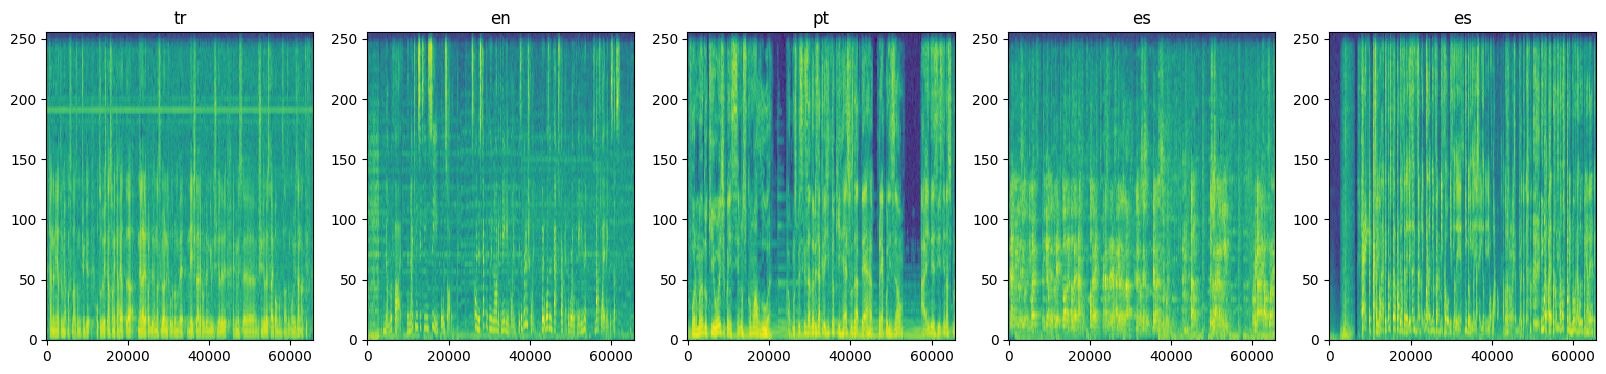

In [28]:
# Show some random samples

def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)


def show_random_samples(data, labels, classes, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 4))
    indices = np.random.choice(len(data), num_samples, replace=False)
    for i, ax in enumerate(axes):
        idx = indices[i]
        spectrogram = data[idx]
        label = classes[np.argmax(labels[idx])]
        plot_spectrogram(spectrogram, ax)
        ax.set_title(label)
    plt.show()


# Show random samples from the test set
show_random_samples(X_test, y_test, classes)

In [8]:
# Dataset cache and prefetch
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.cache()
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [30]:
input_shape = X_train[0].shape

# Normalize the data
norm_layer = tf.keras.layers.Normalization()
norm_layer.adapt(X_train)

model = tf.keras.Sequential([
    Input(shape=input_shape),
    Resizing(32, 32),
    norm_layer,

    # Block 1
    Conv2D(32, 3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.3),

    # Block 2
    Conv2D(64, 3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.3),

    # Block 3
    Conv2D(128, 3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.4),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)           │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_2 (Normalization) │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,875 (1.36 MB)

 Trainable params: 356,424 (1.36 MB)

 Non-trainable params: 451 (1.77 KB)

In [31]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
class EarlyStoppingByAccuracyDiff(tf.keras.callbacks.Callback):
    def __init__(self, threshold=0.2):
        super(EarlyStoppingByAccuracyDiff, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        train_acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')

        if train_acc is not None and val_acc is not None:
            if (train_acc - val_acc) > self.threshold:
                print(f"\nStopping training: train_acc={train_acc}, val_acc={val_acc}, diff={train_acc - val_acc}")
                self.model.stop_training = True

In [33]:
# Define the checkpoint callback to save the latest model
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='latest_model.keras',  # Use the .keras extension
    save_best_only=True,  # Save the best model only at the end of each epoch
    save_weights_only=False,  # Save the entire model
    monitor='val_accuracy',
    verbose=1
)

In [34]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [7]:
model = load_model('latest_model.keras')

In [37]:
early_stop_callback = EarlyStoppingByAccuracyDiff(threshold=0.2)

# Train the model
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[tensorboard_callback, checkpoint_callback, early_stop_callback])

Epoch 1/80
399/400 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7851 - loss: 0.6404
Epoch 1: val_accuracy did not improve from 0.84219
400/400 ━━━━━━━━━━━━━━━━━━━━ 25s 61ms/step - accuracy: 0.7851 - loss: 0.6404 - val_accuracy: 0.8206 - val_loss: 0.5459
Epoch 2/80
399/400 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7844 - loss: 0.6224
Epoch 2: val_accuracy did not improve from 0.84219
400/400 ━━━━━━━━━━━━━━━━━━━━ 25s 61ms/step - accuracy: 0.7844 - loss: 0.6225 - val_accuracy: 0.8278 - val_loss: 0.5339
Epoch 3/80
399/400 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7911 - loss: 0.6163
Epoch 3: val_accuracy did not improve from 0.84219
400/400 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - accuracy: 0.7911 - loss: 0.6164 - val_accuracy: 0.8050 - val_loss: 0.5976
Epoch 4/80
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7841 - loss: 0.6322
Epoch 4: val_accuracy did not improve from 0.84219
400/400 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.7841 - loss: 0.6321 - val_accuracy

In [38]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 8172), started 1 day, 23:10:00 ago. (Use '!kill 8172' to kill it.)

In [39]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.8221874833106995


In [11]:
# Save the model
model.save('audio_classification_model.keras')

# Model prediction on audio

In [40]:
# Load the saved model
model = load_model('latest_model.keras')

target_shape = (128, 128)

# Function to preprocess and classify an audio file
def test_audio(file_path, model):
    # Load and preprocess the audio file
    audio_binary = tf.io.read_file(file_path)
    audio, sample_rate = tf.audio.decode_wav(audio_binary)
    waveform = tf.squeeze(audio, axis=-1)
    mel_spectrogram = get_spectrogram(waveform)
    mel_spectrogram = tf.image.resize(mel_spectrogram, target_shape)
    mel_spectrogram = mel_spectrogram.numpy()
    mel_spectrogram = mel_spectrogram[np.newaxis, ...]
    
    # Make predictions
    predictions = model.predict(mel_spectrogram)
    
    # Get the class probabilities
    class_probabilities = predictions[0]
    
    # Get the predicted class index
    predicted_class_index = np.argmax(class_probabilities)
    
    return class_probabilities, predicted_class_index

# Test an audio file
test_audio_file = "data/de/t-DCUFI97Y4__U__S1---0049.410-0053.360.wav"
class_probabilities, predicted_class_index = test_audio(test_audio_file, model)

# Display results for all classes
for i, class_label in enumerate(classes):
    probability = class_probabilities[i]
    print(f'Class: {class_label}, Probability: {probability:.4f}')

# Calculate and display the predicted class and accuracy
predicted_class = classes[predicted_class_index]
accuracy = class_probabilities[predicted_class_index]
print(f'The audio is classified as: {predicted_class}')
print(f'Accuracy: {accuracy:.4f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
Class: de, Probability: 0.3061
Class: en, Probability: 0.1749
Class: es, Probability: 0.2687
Class: fr, Probability: 0.0130
Class: it, Probability: 0.1563
Class: pt, Probability: 0.0251
Class: ru, Probability: 0.0506
Class: tr, Probability: 0.0054
The audio is classified as: de
Accuracy: 0.3061
